<a href="https://colab.research.google.com/github/pythonuzgit/Large-language-Model/blob/main/Large_Language_Model_using_romeo_and_juliet_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d golammostofas/romeo-and-juliet-tokenization

Dataset URL: https://www.kaggle.com/datasets/golammostofas/romeo-and-juliet-tokenization
License(s): CC0-1.0
  0% 0.00/57.7k [00:00<?, ?B/s]
100% 57.7k/57.7k [00:00<00:00, 49.7MB/s]


In [ ]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

from matplotlib import pyplot as plt

import time

import pandas as pd

import urllib.request

Load the datasets

In [ ]:
lines=open("/content/romeo-and-juliet_tokenization.txt",'r').read()

vocab=sorted(list(set(lines)))

print('Printing the first 10 characters of the vocab list:', vocab[:10])

print('Total number of characters in our dataset (Vocabulary Size):',len(vocab))

Printing the first 10 characters of the vocab list: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-']
Total number of characters in our dataset (Vocabulary Size): 77


Doing mapping

In [ ]:
# mapping integers to characters
itos={i: ch for i, ch in enumerate(vocab)}

# mappping characters to integers
stoi={ch: i for i, ch in enumerate(vocab)}

Tokenizing

In [ ]:
# converts a string to s list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# converts a list of integers to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

Let's apply it to the entire dataset

In [ ]:
dataset=torch.tensor(encode(lines), dtype=torch.int8)

# check the number of tokens in the dataset
print(dataset.shape)

torch.Size([141695])


Split the training dataset

Let's create a function responsible for splitting the dataset into training, validation, or the test sets.

In [ ]:
DEFAULT_CONFIG={
    'batch_size':8, # Number of batches to be processed at each random split
    'context_window':16 # Number of characters in each input (x) and target (y) sequences of each batch
}

In [ ]:
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=DEFAULT_CONFIG):
  train=data[:int(.8 * len(data))]
  val=data[int(.8 *len(data)): int(.9 * len(data))]
  test=data[int(.9 *len(data)):]




  # Determine which split to use
  batch_data=train
  if split=='val':
    batch_data=val

  if split=='test':
    batch_data=test

  # Pick random starting points within the data
  ix=torch.randint(0, batch_data.size(0)-context_window-1,(batch_size,))

  # Create input sequences (x) and corresponding target sequences (y)
  x=torch.stack([batch_data[i:i+context_window] for i in ix]).long()
  y=torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

  return x, y

Here, we are going to print a random sample from the train split of batch 8 and context window 16 from our dataset.

In [ ]:
xs, ys=get_batches(dataset, 'train', DEFAULT_CONFIG['batch_size'], DEFAULT_CONFIG['context_window'])

decoded_samples=[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

print(decoded_samples)

[('ys all senses wi', 's all senses wit'), ('th made me effem', 'h made me effemi'), ('lt stabs Mercuti', 't stabs Mercutio'), ('\nWelcome, gentle', 'Welcome, gentlem'), ('\nDoth grace for ', 'Doth grace for g'), ('n withdraw to th', ' withdraw to the'), ("'er look on libe", 'er look on liber'), ('romised to retur', 'omised to return')]


Evaluation Strategy

In [ ]:
@torch.no_grad()
def evaluate_loss(model, config=DEFAULT_CONFIG):

  out={}

  # Set the model to evaluation mode
  model.eval()

  for split in ["train","val"]:
    losses=[]

    # generate 10 batches for evaluation
    for _ in range(10):
      xb,yb=get_batches(dataset, split, config['batch_size'], config['context_window'])

      # Get inputs sequences (xb) and target sequences (yb)
      _,loss=model(xb,yb)

      losses.append(loss.item())

    out[split]=np.mean(losses)
    # Set the model back to training mode
    model.train()

    return out

Setting Up a Base Neural Network Model

In [ ]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
  def __init__(self, config=DEFAULT_CONFIG):
    super().__init__()
    self.config=config
    # embedding layer to convert character indices to vectors (vocab size: 65)
    self.embedding=nn.Embedding(config['vocab_size'], config['d_model'])
    # Linear layers for modeling relationships between features
    # to be updated with SwiGLU activation function as in LLaMA
    self.linear=nn.Sequential(
        nn.Linear(config['d_model'], config['d_model']),
        nn.ReLU(), # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
        nn.Linear(config['d_model'], config['vocab_size']),
        )
    print("Model parameters:", sum([m.numel() for m in self.parameters()]))

  def forward(self, idx, targets=None):
    # Embedding layer converts character indices to vectors
    x=self.embedding(idx)

    # Linear layers for modeling relationships between features
    a=self.linear(x)
    # Apply softmax activation to obtain probability distribution
    logits=F.softmax(a, dim=-1)

    # If targets are provided, calculate and return the cross-entropy loss
    if targets is not None:
      # Reshape logits and targets for cross-entripy calculation
      loss=F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))

      return logits, loss
        # If targets are nor provide
        # If targets are nor provided, return the logits

    else:
      return logits

In [ ]:
DEFAULT_CONFIG.update({
    'd_model':128,
    'vocab_size':len(vocab)
})

model=SimpleBrokenModel(DEFAULT_CONFIG)

print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))

Model parameters: 36301
Total number of parameters in the Simple Neural Network Model: 36301


Computing logits and loss

In [ ]:
xs, ys=get_batches(dataset, 'train' , DEFAULT_CONFIG['batch_size'], DEFAULT_CONFIG['context_window'])
logits, loss=model(xs, ys)

In [ ]:
logits

tensor([[[0.0172, 0.0110, 0.0106,  ..., 0.0161, 0.0153, 0.0150],
         [0.0146, 0.0164, 0.0117,  ..., 0.0169, 0.0160, 0.0118],
         [0.0095, 0.0087, 0.0072,  ..., 0.0109, 0.0152, 0.0130],
         ...,
         [0.0102, 0.0085, 0.0121,  ..., 0.0125, 0.0157, 0.0114],
         [0.0158, 0.0146, 0.0114,  ..., 0.0163, 0.0183, 0.0114],
         [0.0217, 0.0112, 0.0112,  ..., 0.0152, 0.0215, 0.0132]],

        [[0.0095, 0.0087, 0.0072,  ..., 0.0109, 0.0152, 0.0130],
         [0.0102, 0.0085, 0.0121,  ..., 0.0125, 0.0157, 0.0114],
         [0.0109, 0.0107, 0.0101,  ..., 0.0155, 0.0145, 0.0098],
         ...,
         [0.0217, 0.0112, 0.0112,  ..., 0.0152, 0.0215, 0.0132],
         [0.0117, 0.0121, 0.0117,  ..., 0.0135, 0.0264, 0.0176],
         [0.0138, 0.0121, 0.0120,  ..., 0.0116, 0.0133, 0.0117]],

        [[0.0087, 0.0129, 0.0101,  ..., 0.0135, 0.0160, 0.0113],
         [0.0138, 0.0121, 0.0120,  ..., 0.0116, 0.0133, 0.0117],
         [0.0156, 0.0126, 0.0096,  ..., 0.0159, 0.0129, 0.

In [ ]:
loss

tensor(4.3438, grad_fn=<NllLossBackward0>)

Training

In [ ]:
DEFAULT_CONFIG.update({
    'epochs':1000,        # Number of training epochs
    'log_interval': 10,   # Log information every 10 batches during training
    'batch_size': 32,     # Increase batch size to 32
})

model=SimpleBrokenModel(DEFAULT_CONFIG)

# Define the Adam optimizer for model parameters
optimizer=torch.optim.Adam(
    model.parameters(),   # Pass the model parameters to the optimizer
)

Model parameters: 36301


In [ ]:
DEFAULT_CONFIG

{'batch_size': 32,
 'context_window': 16,
 'd_model': 128,
 'vocab_size': 77,
 'epochs': 1000,
 'log_interval': 10}

Validation loss: {'train': 4.106500720977783}


<Axes: >

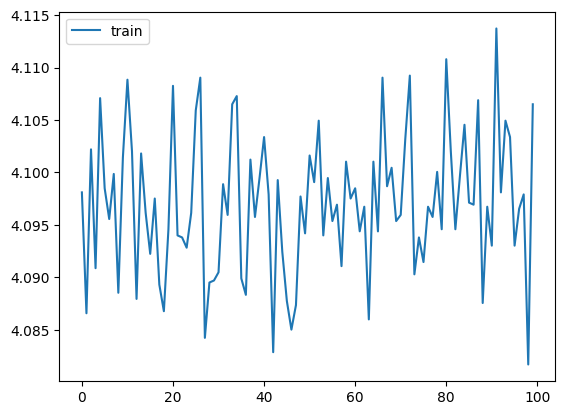

In [ ]:
def train(model, optimizer, scheduler=None, config=DEFAULT_CONFIG, print_logs=False):
    losses=[]

    start_time=time.time()

    for epoch in range(config['epochs']):
        #Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        #Forward pass through the model to calculate logits and loss
        logits, loss =model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval']==0:
            # Calculate batch time
            batch_time=time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation losss
            losses+=[x] # Assuming evaluate_loss returns a single value

            # Print progress logs if specified
            if print_logs:
                # Access the loss directly since it's not a dictionary
                print(f"Epoch {epoch}| val loss {x:.3f} | Time {batch_time:.3f}|ETA in seconds {batch_time*(config['epochs']-epoch)/config['log_interval']:.3f}")

            # Reset the timer
            start_time=time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    if losses:
        # Access the loss directly since it's not a dictionary
        print("Validation loss:", losses[-1])
    else:
      print("No losses recorded")

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

train(model, optimizer)